In [1]:
import models
import os
import numpy as np
import json
from scipy.misc import imread, imresize
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
from PIL import Image
import torch

In [21]:
checkpoint = './best_checkpoints/BEST_checkpoint_caption_data_att_49_dec_500_drop_0.25_RESNET.pth.tar'
checkpoint = torch.load(checkpoint,map_location='cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

with open('./best_checkpoints/WORDMAP_.json', 'r') as j:
    word_map = json.load(j)

rev_word_map = {v: k for k, v in word_map.items()}  # idx2word

/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'models.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


ModuleNotFoundError: No module named 'pretrainedmodels'

In [3]:
def predict_output(image): 
    """
    Predict output with beam size of 1 (predict the word and feed it to the next LSTM). 
    Prints out the generated sentence
    """
    max_len = 20
    sampled = []
    rev_word_map = {v: k for k, v in word_map.items()}  # idx2word
    img = imread(image)
    img = imresize(img, (224, 224))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 224, 224)
    # Encode
    image = image.unsqueeze(0)  # (1, 3, 224, 224)
    spatial_image, global_image, enc_image = encoder(image)
    pred = torch.LongTensor([[word_map['<start>']]]).to(device)   # (1, 1)  
    num_pix = spatial_image.shape[1]
    alphas_stored = torch.zeros(max_len, num_pix)
    betas_stored = torch.zeros(max_len,1)
    h,c = decoder.init_hidden_state(enc_image)                    #  (1,hidden_size)

    for timestep in range(max_len):
        embeddings = decoder.embedding(pred).squeeze(1)       # (1,1,embed_dim) --> (1,embed_dim)    
        inputs = torch.cat((embeddings,global_image), dim = 1)    # (1, embed_dim * 2)
        h, c, st = decoder.LSTM(inputs, (h, c))  # (1, hidden_size)
        # Run the adaptive attention model
        alpha_t, beta_t, c_hat = decoder.adaptive_attention(spatial_image,h,st)
        # Compute the probability
        pt = decoder.fc(c_hat + h)  
        _,pred = pt.max(1)
        sampled.append(pred.item())
        alphas_stored[timestep] = alpha_t
        betas_stored[timestep] = beta_t
        #print(beta_t)
    generated_words = [rev_word_map[sampled[i]] for i in range(len(sampled))]
    filtered_words = ' '.join([word for word in generated_words if word != '<end>'])

    print(filtered_words)

In [4]:
# Implementation with Beam Search
import torch.nn.functional as F
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    
    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (224, 224))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 224, 224)
    # Encode
    image = image.unsqueeze(0)  # (1, 3, 224, 224)
    spatial_image, global_image, encoder_out = encoder(image) #enc_image of shape (batch_size,num_pixels,features)
    # Flatten encoding
    num_pixels = encoder_out.size(1)
    encoder_dim = encoder_out.size(2)
    enc_image_size = 7     
    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)
    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)
    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)
    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)
    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)
    #Tensor to store the top k sequences betas
    seqs_betas = torch.ones(k,1,1).to(device) 
    # Lists to store completed sequences, their alphas, betas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()
    complete_seqs_betas = list()       
    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)
    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:
        embeddings = decoder.embedding(k_prev_words).squeeze(1)  
        inputs = torch.cat((embeddings,global_image.expand_as(embeddings)), dim = 1)
        h, c, st = decoder.LSTM(inputs, (h, c))  # (1, hidden_size)
        # Run the adaptive attention model
        alpha_t, beta_t, c_hat = decoder.adaptive_attention(spatial_image,h,st)
        alpha = alpha_t.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)
        # Compute the probability
        scores = decoder.fc(c_hat + h) 
        scores = F.log_softmax(scores, dim=1)   # (s, vocab_size)
        # Add
        # (k,1) will be (k,vocab_size), then (k,vocab_size) + (s,vocab_size) --> (s, vocab_size)
        scores = top_k_scores.expand_as(scores) + scores  
        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            #Remember: torch.topk returns the top k scores in the first argument, and their respective indices in the second argument
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s) 
        next_word_inds = top_k_words % vocab_size  # (s) 
        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        # (s, step+1, enc_image_size, enc_image_size)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],dim=1)  
        seqs_betas = torch.cat([seqs_betas[prev_word_inds], beta_t[prev_word_inds].unsqueeze(1)], dim=1)  

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
            complete_seqs_betas.extend(seqs_betas[complete_inds])   
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]              
        seqs_alpha = seqs_alpha[incomplete_inds]   
        seqs_betas = seqs_betas[incomplete_inds]    
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]
    betas = complete_seqs_betas[i]          
    return seq, alphas, betas     

In [22]:
def visualize_att(image_path, seq, alphas, betas, rev_word_map, smooth=True, imgname=""):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    size = 24
    image = Image.open(image_path)
    print(image.size)
    image = image.resize([224,224], Image.LANCZOS)
    words = [rev_word_map[ind] for ind in seq]
    print(' '.join(words[1:-1]))

    for t in range(len(words)):
        if t > 30:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)
        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=30)
        #plt.text(0,224, "{}".format(1-betas[t].item()), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [224,224])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("../visualization/{}_visualization".format(imgname))
    plt.show()
    plt.tight_layout()



In [6]:
def visualize_att_linear(image_path, seq, alphas, betas, rev_word_map, smooth=True, imgname=""):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    size = 24
    image = Image.open(image_path)
    print(image.size)
    image = image.resize([224,224], Image.LANCZOS)
    words = [rev_word_map[ind] for ind in seq]
    print(' '.join(words[1:-1]))
    grid = plt.GridSpec(1, len(words), wspace=0., hspace=0.)

    for t in range(len(words)):
        if t > 30:
            break
#        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)
        plt.subplot(grid[0,t])
        plt.text(95, 210, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=30, horizontalalignment='center')
#        plt.text(0,224, "{:.4f}".format(1-betas[t].item()), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [224,224])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.savefig("../visualization/{}_visualization".format(imgname))
    plt.show()


In [7]:
print("Output with no beam search:")
imgname = "super_sumo"
img = "png/{}.png".format(imgname)
img = "../a-PyTorch-Tutorial-to-Image-Captioning/img/babycake.png"
img = "../coco_images/val/COCO_val2014_000000000136.jpg"
img = "../coco_images/val/COCO_val2014_000000000872.jpg"
img = "../coco_images/train/COCO_train2014_000000000036.jpg"
    
predict_output(img)

Output with no beam search:


/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  # Remove the CWD from sys.path while we load stuff.


a woman in a red dress holding a pink umbrella and


/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [8]:
img

'../coco_images/train/COCO_train2014_000000000036.jpg'

/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  del sys.path[0]


Output with Beam Size = 3
(481, 640)
a woman holding an umbrella in front of a wall


/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


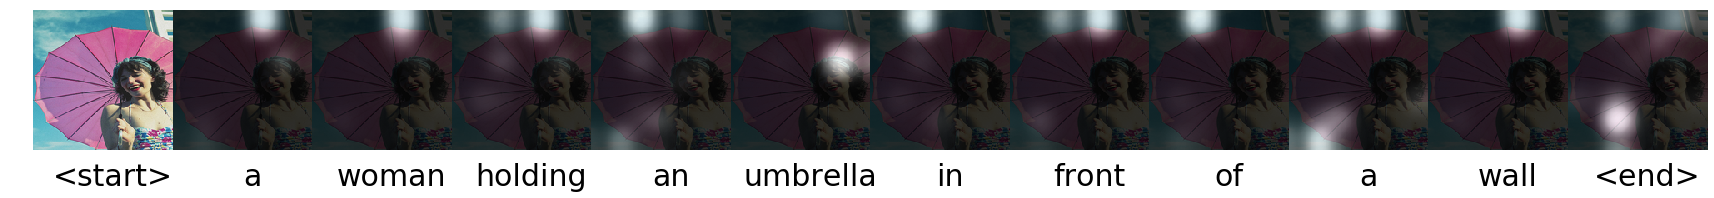

In [9]:
print("Output with Beam Size = 3")
%matplotlib inline
plt.rcParams['figure.figsize'] = (30, 30)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.tight_layout()
# Encode, decode with attention and beam search k=3
seq, alphas, betas = caption_image_beam_search(encoder, decoder, img, word_map)
alphas = torch.FloatTensor(alphas)
# Visualize caption and attention of best sequence
visualize_att_linear(img, seq, alphas, betas, rev_word_map,smooth=True,imgname=imgname )


Output with Beam Size = 3


/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  del sys.path[0]
/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is 

(481, 640)
a woman holding an umbrella in front of a wall


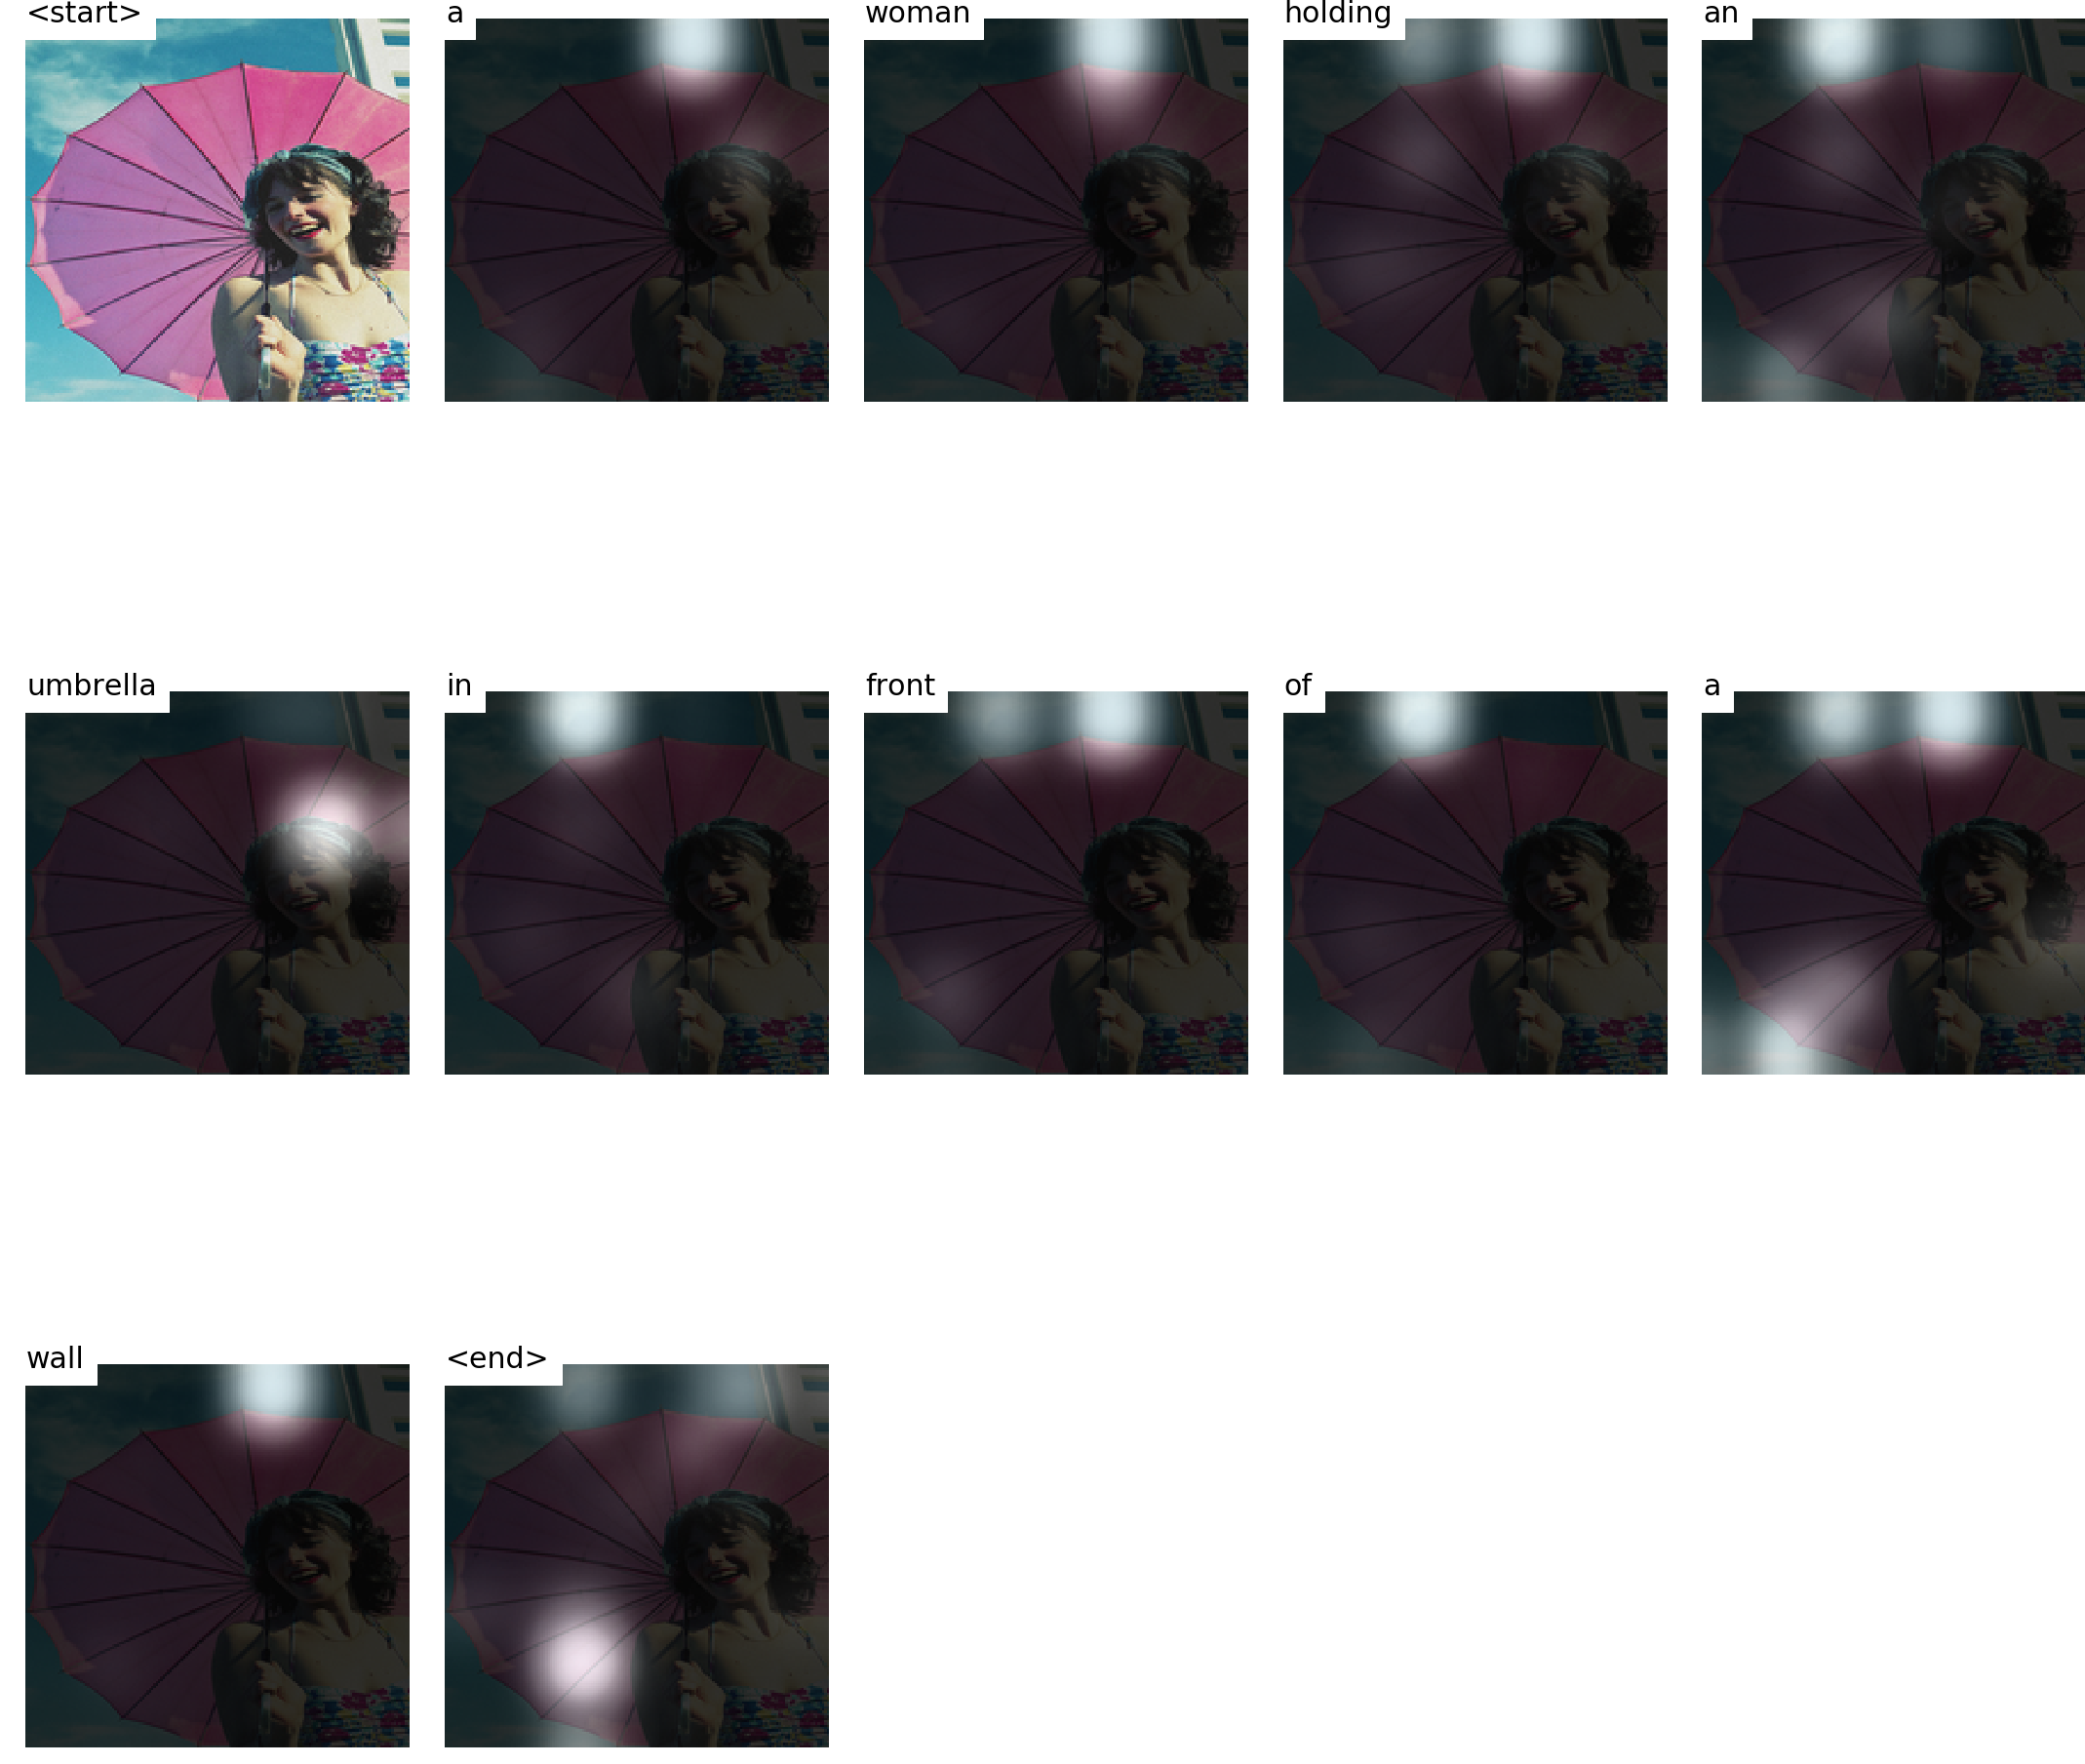

<Figure size 2160x2160 with 0 Axes>

In [23]:
print("Output with Beam Size = 3")
%matplotlib inline
plt.rcParams['figure.figsize'] = (30, 30)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.tight_layout()
# Encode, decode with attention and beam search k=3
seq, alphas, betas = caption_image_beam_search(encoder, decoder, img, word_map)
alphas = torch.FloatTensor(alphas)
# Visualize caption and attention of best sequence
visualize_att(img, seq, alphas, betas, rev_word_map,smooth=True,imgname=imgname )


Output with Beam Size = 3


/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  del sys.path[0]


a woman holding an umbrella in front of a wall


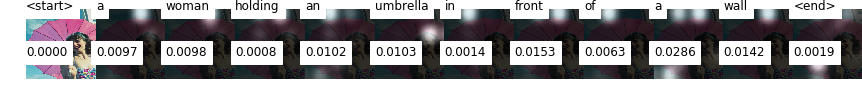

In [15]:
print("Output with Beam Size = 3")
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['savefig.pad_inches'] = 0
plt.tight_layout()
# Encode, decode with attention and beam search k=3
seq, alphas, betas = caption_image_beam_search(encoder, decoder, img, word_map)
seq, alphas, betas = caption_image_beam_search(encoder, decoder, img, word_map)
alphas = torch.FloatTensor(alphas)
smooth = True
vgprob = 1-betas
image_path="../coco_images/train/COCO_train2014_000000000036.jpg"
image = Image.open(image_path)
image = image.resize([224,224], Image.LANCZOS)
words = [rev_word_map[ind] for ind in seq]
print(' '.join(words[1:-1]))
grid = plt.GridSpec(1, len(words), wspace=0., hspace=0.)
for t in range(len(words)):
    if t > 30:
        break
    plt.subplot(grid[0,t])
    plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
    plt.text(0,112, "{:.4f}".format(1-betas[t].item()), color='black', backgroundcolor='white', fontsize=12)
    plt.imshow(image)
    current_alpha = alphas[t, :]
    if smooth:
        alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
    else:
        alpha = skimage.transform.resize(current_alpha.numpy(), [224,224])
    if t == 0:
        plt.imshow(alpha, alpha=0)
    else:
        plt.imshow(alpha, alpha=0.8)
    plt.set_cmap(cm.Greys_r)
    plt.axis('off')
plt.savefig("../visualization/{}_visualization".format(imgname))
plt.show()

/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/Users/weitat/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  del sys.path[0]


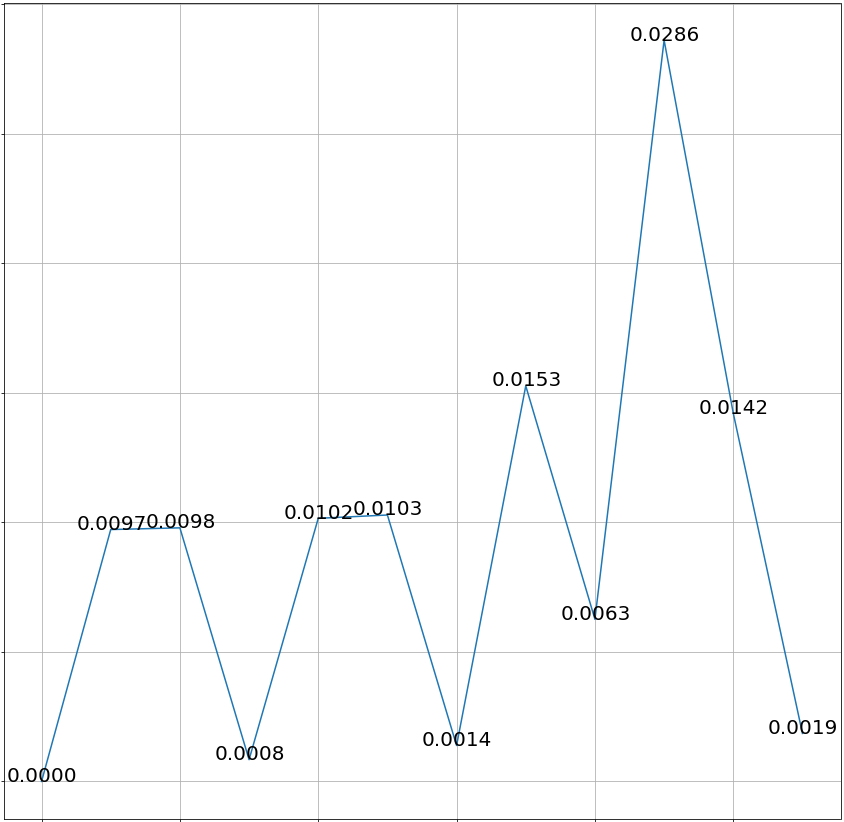

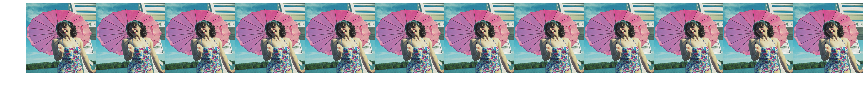

In [14]:

fig = plt.figure
seq, alphas, betas = caption_image_beam_search(encoder, decoder, img, word_map)
alphas = torch.FloatTensor(alphas)
beta_ = betas.tolist()
beta__ = np.array(beta_).flatten()
beta__ = 1-beta__
grid = plt.GridSpec(2, len(words), wspace=0., hspace=0.)

ax = plt.subplot(111)
plt.plot(range(len(beta_)),np.array(beta__).flatten())

ax.tick_params(labelbottom=False,labelleft=False)


for i, txt in enumerate(beta__):
    ax.annotate("{:.4f}".format(txt), (range(len(beta__))[i]-0.5, beta__[i]),size=20)
plt.grid()
plt.savefig("../visualization/ground_prob")

plt.show()

for t in range(len(words)):
    plt.subplot(grid[1,t])
    plt.imshow(image)
    
    plt.axis("off")
plt.show()


In [12]:
alphas

tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]],

        [[0.0204, 0.0204, 0.0204, 0.0204, 0.0205, 0.0204, 0.0204],
         [0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204],
         [0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204],
         [0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204],
         [0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204],
         [0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204],
         [0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204]],

        [[0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 0.0204, 